##Topic modeling

In [ ]:
!pip -q install sentence-transformers
!pip -q install hdbscan
!pip -q install transformers
!pip -q install langdetect

     |████████████████████████████████| 71kB 1.9MB/s 
     |████████████████████████████████| 1.1MB 7.7MB/s 
     |████████████████████████████████| 890kB 19.2MB/s 
     |████████████████████████████████| 3.0MB 28.8MB/s 
     |████████████████████████████████| 1.1MB 35.7MB/s 
     |████████████████████████████████| 4.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 983kB 2.8MB/s 


### Import Libraries

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pickle
import pandas as pd
import numpy as np
import nltk
import string
import re
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from langdetect import detect


model = SentenceTransformer('distilbert-base-nli-mean-tokens')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
import requests

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

100%|██████████| 245M/245M [00:21<00:00, 11.4MB/s]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Data preprocessing

In [ ]:
def filtering(row):
  

  #s=re.sub(r'\d+', '', row['Description'])
  s=row['Description']
  lemmatizer = WordNetLemmatizer() 
  porter = PorterStemmer()
  stop_words = set(stopwords.words('english')) 

  #Tokenization
  word_tokens=nltk.word_tokenize(s.lower())
  #remove stop words
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  #remove punctuatio
  filtered_sentence = [w for w in filtered_sentence if not w in string.punctuation] 
  #stemming
  filtered_sentence = [porter.stem(w) for w in filtered_sentence]
  #lemmatization
  filtered_sentence = [lemmatizer.lemmatize(w) for w in filtered_sentence]

  return " ".join(filtered_sentence)

def detect_language(row):
    try:
      return detect(row["Description"])
    except:
      return None

df=pd.read_csv("/content/data_startups - data_french.csv")
df=df.dropna()
df["language"]=df.apply(detect_language,axis=1)
df['Description_cleaned'] = df.apply(filtering, axis=1) 
df=df[df.language=="en"]
docs=df['Description']
docs_cleaned=df['Description_cleaned']
#dropping row containing non-english words
df.head(10)

,Name,urlwebsite,Description French,Description,language,Description_cleaned
0,1food1me,https://1food1me.com,Votre corps sait ce dont il a besoin. Apprenez...,Your body knows what it needs. Learn it well. ...,en,bodi know need learn well biolog custom nutrit...
1,appines,https://www.appines.fr/,Télécharge la 1ère app de recrutement de rempl...,"Download 1st app recruitment of substitutes, a...",en,download 1st app recruit substitut assist phys...
2,interstis,https://interstis.fr/,Formulaire de recrutement d'interstis,Recruitment Form InterSTIS,en,recruit form intersti
3,kshuttle,https://www.kshuttle.io/fr/,kShuttle.io offre une vision unifiée de l'effi...,kShuttle.io provides a unified view of operati...,en,kshuttle.io provid unifi view oper effici risk...
5,citizenwave,https://www.citizenwave.com/,"Découvrez Citizenwave, la Plateforme analytiqu...","Discover Citizenwave, collaborative analytic p...",en,discov citizenwav collabor analyt platform com...
6,darlow,https://darlowparis.com,"Agence fondée par une artiste, votre site sera...","Agency founded by an artist, your site will be...",en,agenc found artist site done artist vision 100...
8,teambrain,https://teambrain.fr/,TeamBrain c'est automatiser les réponses ✔️ sa...,TeamBrain is automate responses ✔️ without set...,en,teambrain autom respons ✔️ without setup ✔️ se...
9,luxurynsight,https://www.luxurynsight.com/,Combining the best of data science and luxury ...,Combining the best of science data and luxury ...,en,combin best scienc data luxuri expertis luxury...
10,captain-achat,https://www.captainachat.com,"Entièrement dédié aux artisans, TPE et PME, Ca...","Entirely dedicated to the craftsmen, small and...",en,entir dedic craftsman small micro busi captain...
11,trapeze-des-mascareignes,https://trapeze-des-mascareignes.site/,Le trapèze des Mascareignes est un archipel co...,The trapeze of the Mascarene Islands is an arc...,en,trapez mascaren island archipelago compos five...


In [ ]:
df_ = df[['Description','Description_cleaned','urlwebsite',"language"]]
df_.style.set_properties(subset=['Description'], **{'width': '300px'})

,Description,Description_cleaned,urlwebsite,language
0,Your body knows what it needs. Learn it well. You and your biology. Your customized nutrition. 1Food1Me helps you know your,bodi know need learn well biolog custom nutrit 1food1m help know,https://1food1me.com,en
1,"Download 1st app recruitment of substitutes, assistants and physiotherapists employees in France and overseas territories. Ads and contracts physios",download 1st app recruit substitut assist physiotherapist employe franc oversea territori ad contract physio,https://www.appines.fr/,en
2,Recruitment Form InterSTIS,recruit form intersti,https://interstis.fr/,en
3,kShuttle.io provides a unified view of operational efficiency and risk management. kShuttle erases the boundaries between business managers and hierarchies.,kshuttle.io provid unifi view oper effici risk manag kshuttl era boundari busi manag hierarchi,https://www.kshuttle.io/fr/,en
5,"Discover Citizenwave, collaborative analytic platform commitment of people and organizations in a collective eco-responsible approach",discov citizenwav collabor analyt platform commit peopl organ collect eco-respons approach,https://www.citizenwave.com/,en
6,"Agency founded by an artist, your site will be done with an artistic vision. You are 100% sure to have a beautiful & modern aesthetic site.",agenc found artist site done artist vision 100 sure beauti modern aesthet site,https://darlowparis.com,en
8,TeamBrain is automate responses ✔️ without setup ✔️ self-learning ✔️ use unlimited ✔️ and multilingual!,teambrain autom respons ✔️ without setup ✔️ self-learn ✔️ use unlimit ✔️ multilingu,https://teambrain.fr/,en
9,Combining the best of science data and luxury expertise. Luxurynsight's smart data platform and data services Provide insights to luxury leading luxury brands.,combin best scienc data luxuri expertis luxurynsight 's smart data platform data servic provid insight luxuri lead luxuri brand,https://www.luxurynsight.com/,en
10,"Entirely dedicated to the craftsmen, small and micro businesses, Captain purchase is up to 30% savings in the year on your IT purchases. Discover our offers!",entir dedic craftsman small micro busi captain purchas 30 save year purchas discov offer,https://www.captainachat.com,en
11,"The trapeze of the Mascarene Islands is an archipelago composed of five main islands, it is a real natural sanctuary wildlife and flora.",trapez mascaren island archipelago compos five main island real natur sanctuari wildlif flora,https://trapeze-des-mascareignes.site/,en


In [ ]:
len(docs)

2593

### Data encoding

BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

For Retriveing the  BERT embeddings, we apply Encoding on clear text not cleaned one,it will give better results.
<br>
We use the cleaned text when we want to extract most important keywords in each cluster (c-tf-idf)


In [ ]:
embeddings = model.encode(list(docs), show_progress_bar=True)

### Dimensionality reduction

Before doing the clustring, we first need to lower the dimensionality of the embeddings as many clustering algorithms handle high dimensionality poorly.

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=4, 
                            metric='cosine').fit_transform(embeddings)

### Clustring

In [ ]:
import hdbscan
from sklearn.cluster import Birch
cluster = hdbscan.HDBSCAN(min_cluster_size=12,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

cluster=KMeans(n_clusters=12, random_state=0).fit(umap_embeddings)
cluster = Birch(n_clusters=None).fit(umap_embeddings)


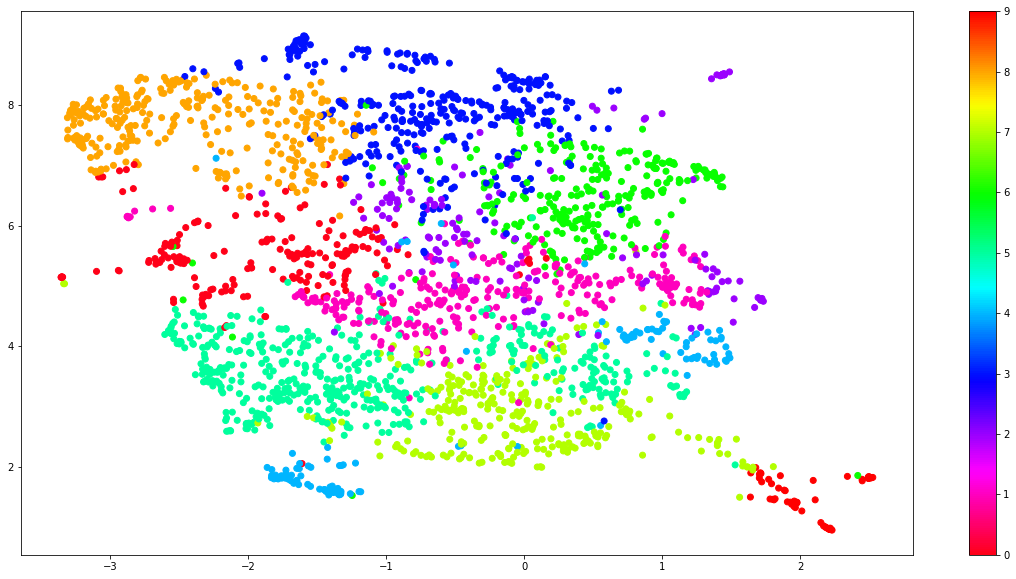

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
cluster2 = Birch(n_clusters=10).fit(umap_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster2.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
plt.colorbar()

### Keyword extraction for each cluster

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

docs_cleaned=df['Description_cleaned']
docs_startups_urls=df['urlwebsite']

docs_df = pd.DataFrame(list(docs_cleaned), columns=["Doc"])
docs_df["urlwebsite"]=list(docs_startups_urls)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(list(docs_cleaned)))

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes

,Topic,Size
12,12,82
58,58,70
69,69,69
66,66,51
17,17,48
...,...,...
78,78,4
79,79,3
118,118,2
70,70,2


### Determine the topic of each cluster

In [ ]:
df_1 = pd.DataFrame(top_n_words)
df_1=df_1.applymap(lambda row: str(row[0])+":"+str(round(row[1], 2)))
df_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121
0,pair:0.17,page:0.78,sinch:0.21,dpo:0.09,relat:0.97,ssc:0.18,profession:0.18,improv:0.14,manag:0.08,innov:0.08,solut:0.06,home:0.19,digit:0.08,data:0.09,hr:0.17,financi:0.1,kionect:0.08,ai:0.1,right:0.15,startup:0.09,mingzi:0.14,tomorrow:0.09,seo:0.14,busi:0.14,kayrro:0.06,estat:0.17,ecommerc:0.2,onlin:0.11,mobil:0.26,better:0.05,manag:0.07,game:0.15,diseas:0.11,happi:0.07,wast:0.08,walk:0.17,local:0.09,improv:0.14,room:0.14,digit:0.08,...,code:0.04,theoria:0.08,sound:0.11,favorit:0.11,onlin:0.11,game:0.21,free:0.13,electr:0.12,facebook:0.24,montessori:0.1,onlin:0.08,best:0.07,free:0.08,fastest:0.13,car:0.17,hour:0.07,tax:0.1,wireless:0.08,100:0.14,nice:0.09,easili:0.14,wine:0.11,free:0.12,easier:0.38,easili:0.09,daili:0.13,android:0.19,lifestick:0.1,minsar:0.39,simpl:0.12,smartphon:0.19,europ:0.07,equip:0.18,one4y:0.14,guitar:0.1,selectra:0.17,packag:0.4,home:0.11,booth:0.14,april:0.18
1,ev:0.17,look:0.31,seater:0.12,optim:0.08,link:0.89,cdi:0.12,key:0.17,perform:0.1,expens:0.08,urban:0.06,market:0.06,senior:0.15,secur:0.06,boost:0.06,employe:0.14,softwar:0.07,octopuls:0.08,intellig:0.07,person:0.08,servic:0.06,invest:0.11,data:0.07,googl:0.09,franchis:0.14,better:0.06,real:0.14,sale:0.13,email:0.09,advertis:0.09,evolut:0.05,commerc:0.07,user:0.12,develop:0.07,sport:0.06,energi:0.08,sleep:0.13,trade:0.08,light:0.14,prestashop:0.08,innov:0.06,...,key:0.04,bereav:0.08,high:0.05,star:0.08,free:0.1,dash:0.08,cheap:0.08,android:0.09,instagram:0.17,logic:0.1,minut:0.08,stand:0.07,creat:0.08,way:0.09,use:0.1,free:0.07,card:0.07,woodi:0.08,free:0.12,travel:0.08,electr:0.13,price:0.09,badg:0.07,medic:0.17,onlin:0.08,carpool:0.12,itun:0.17,road:0.09,quest:0.21,custom:0.06,tv:0.18,wine:0.07,buy:0.16,enhanc:0.1,job:0.09,dollar:0.13,ridg:0.31,care:0.11,person:0.13,20190:0.15
2,sole:0.16,nou:0.29,nephelai:0.12,program:0.07,look:0.77,leeto:0.11,whenev:0.14,effect:0.09,offer:0.08,new:0.06,contact:0.05,retir:0.11,data:0.05,custom:0.05,job:0.07,payment:0.07,mercateam:0.08,artifici:0.07,knowledg:0.08,special:0.06,foxnot:0.1,essenti:0.06,social:0.06,onlin:0.11,increas:0.05,law:0.08,payment:0.1,lawyer:0.08,convers:0.07,train:0.05,platform:0.06,api:0.1,therapeut:0.07,easili:0.06,queue:0.08,question:0.07,new:0.08,usb:0.13,retir:0.08,technolog:0.05,...,build:0.04,famili:0.08,glass:0.05,recommend:0.07,tattoo:0.08,quiz:0.08,app:0.05,free:0.07,bio:0.12,alia:0.1,quickli:0.06,campsit:0.06,password:0.07,easi:0.09,vehicl:0.09,oblig:0.05,calcul:0.07,touch:0.07,boosteus:0.07,famili:0.07,car:0.12,free:0.09,fish:0.04,artist:0.12,mosaic:0.07,artwork:0.1,connect:0.17,free:0.08,leap:0.19,pcr:0.06,tablet:0.18,escap:0.07,vendor:0.16,tour:0.1,lesson:0.09,reduc:0.11,bok:0.31,plant:0.1,edibl:0.11,cours:0.13
3,charg:0.12,unabl:0.29,babysittor:0.12,legal:0.07,entoureo:0.12,criteo:0.11,threshold:0.14,emot:0.09,header:0.07,solut:0.06,data:0.05,help:0.09,cyber:0.04,audienc:0.05,manag:0.06,account:0.05,easy:0.08,develop:0.06,place:0.06,platform:0.05,badakan:0.1,experi:0.06,market:0.05,logo:0.1,help:0.05,lawyer:0.08,store:0.1,law:0.06,frontlin:0.07,innov:0.05,singl:0.06,interact:0.09,medic:0.06,network:0.06,hr:0.07,day:0.07,welcom:0.06,arch:0.13,busi:0.08,acceler:0.04,...,websit:0.03,check:0.08,theater:0.05,win:0.07,survey:0.06,player:0.08,parcel:0.04,bike:0.07,shell:0.1,cod:0.09,shop:0.06,price:0.05,safe:0.07,peopl:0.08,purchas:0.07,100:0.05,rent:0.07,univers:0.06,legal:0.07,rent:0.06,shopinzen:0.11,ski:0.08,telecom:0.04,exchang:0.12,resum:0.07,milesboost:0.1,io:0.15,watchdog:0.07,magic:0.18,easi:0.05,iphon:0.14,licens:0.07,legal:0.11,holiday:0.1,footbal:0.09,supplier:0.1,occup:0.31,staff:0.1,plea:0.1,student:0.08
4,hous:0.1,dri:0.26,thinker:0.12,support:0.06,book:0.1,manag:0.1,outsid:0.14,knowledg:0.08,bid:0.07,climat:0

In [ ]:
docs_df[docs_df.Topic==3].head(20)

,Doc,urlwebsite,Topic,Doc_ID
86,never easier find new custom,https://www.salesby.tech/,3,86
430,receiv make call compani pc mac smartphon ivr ...,http://www.digimium.com,3,430
522,captain wallet allow brand establish autom mar...,https://www.captainwallet.com/,3,522
575,exchang letter medic health profession patient...,https://www.lifen.fr/,3,575
702,never easier team creat share improv train tog...,https://fr.360learning.com/,3,702
794,audio content applic inspir develop perform do...,https://www.majelan.com/,3,794
806,care execut buyer manag medic transport never ...,https://www.ambler.fr/,3,806
821,big day suppos happiest day life 's lot stress...,http://www.jourj.fr,3,821
1043,bilmobil book home repair store 7d 7 ile de fr...,https://bilmobile.com/,3,1043
1078,photo applic ident smartphon id make onlin ide...,https://www.smartphone-id.com/,3,1078
